Processing folders (this may take a moment)...
Checking processed JSON files...
Successfully created /home/gavinfarrell/PhD_Code/DOME_Top_Curate/checker.tsv

DOME Registry Checker Analysis Report
Total Entries: 275
Processed JSONs Found: 240
Entries Flagged for Processing (Not processed + PDF & Supp available): 0

Data Availability:
- PDF Downloadable: 239
- Supplementary Downloadable: 239

Folder Integrity:
- Empty Folders (where PMCID exists): 0


Analysis report saved to /home/gavinfarrell/PhD_Code/DOME_Top_Curate/checker_analysis.txt
Analysis plot saved to /home/gavinfarrell/PhD_Code/DOME_Top_Curate/checker_analysis.png
Analysis plot saved to /home/gavinfarrell/PhD_Code/DOME_Top_Curate/checker_analysis.png


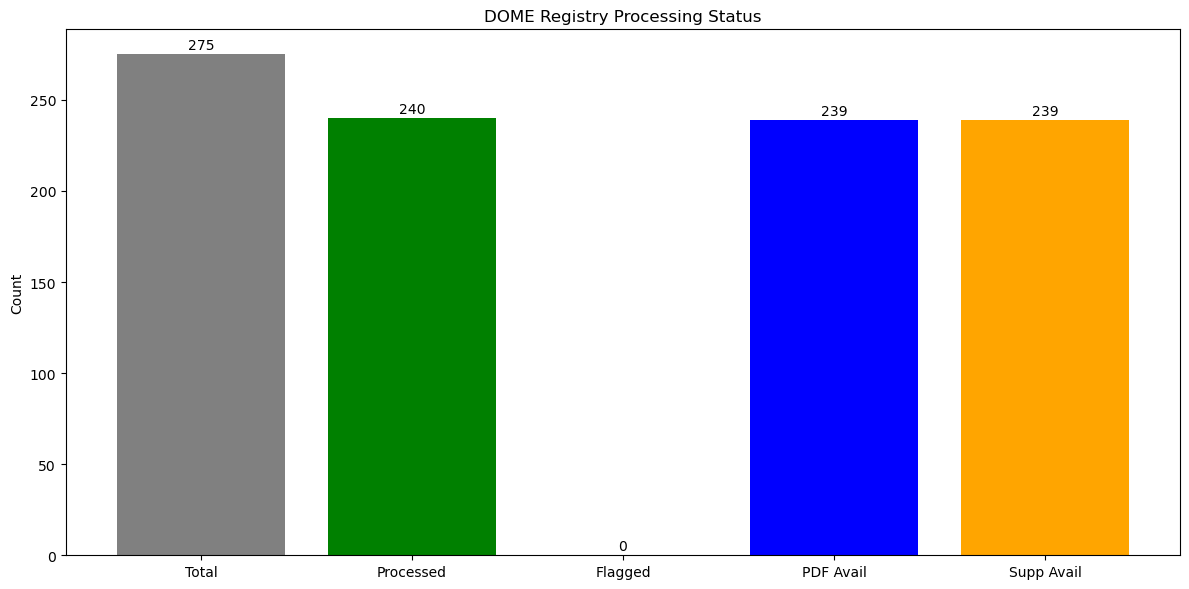

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Define paths
input_file = '/home/gavinfarrell/PhD_Code/DOME_Top_Curate/DOME_Registry_TSV_Files/PMCIDs_DOME_Registry_Contents_2025-11-25_merged.tsv'
output_file = '/home/gavinfarrell/PhD_Code/DOME_Top_Curate/checker.tsv'
supplementary_dir = '/home/gavinfarrell/PhD_Code/DOME_Top_Curate/DOME_Registry_PMC_Supplementary'
processed_json_dir = '/home/gavinfarrell/PhD_Code/DOME_Top_Curate/Copilot_v0_Processed_2025-12-04/registry_v0'
analysis_text_file = '/home/gavinfarrell/PhD_Code/DOME_Top_Curate/checker_analysis.txt'
analysis_plot_file = '/home/gavinfarrell/PhD_Code/DOME_Top_Curate/checker_analysis.png'

def get_folder_info(pmcid):
    # Initialize with NAs
    result = {
        'actual_file_count': pd.NA,
        'main_pdf_filename': pd.NA,
        'is_folder_empty': pd.NA,
        'folder_size_mb': pd.NA
    }
    
    if pd.isna(pmcid):
        return pd.Series(result)
    
    folder_path = os.path.join(supplementary_dir, str(pmcid))
    
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        try:
            files = os.listdir(folder_path)
            file_count = len(files)
            
            # Check for main PDF
            expected_pdf = f"{pmcid}_main.pdf"
            main_pdf_name = expected_pdf if expected_pdf in files else pd.NA
            
            # Empty folder check
            is_empty = (file_count == 0)
            
            # Calculate size in MB
            total_size = 0
            for f in files:
                fp = os.path.join(folder_path, f)
                if os.path.isfile(fp):
                    total_size += os.path.getsize(fp)
            size_mb = round(total_size / (1024 * 1024), 2)
            
            result['actual_file_count'] = file_count
            result['main_pdf_filename'] = main_pdf_name
            result['is_folder_empty'] = is_empty
            result['folder_size_mb'] = size_mb
            
        except Exception as e:
            print(f"Error accessing {folder_path}: {e}")
            
    return pd.Series(result)

def check_processed_json(pmcid):
    if pd.isna(pmcid):
        return pd.NA
    
    json_filename = f"{pmcid}.json"
    json_path = os.path.join(processed_json_dir, json_filename)
    
    if os.path.exists(json_path):
        return json_filename
    else:
        return pd.NA

# Read the TSV file
try:
    df = pd.read_csv(input_file, sep='\t')
    
    # Select and reorder columns
    selected_columns = [
        'publication_title', 
        'shortid', 
        'mapped_pmcid', 
        'mapped_pmid', 
        'pdf_downloadable', 
        'supplementary_downloadable', 
        'supplementary_file_count', 
        'supplementary_file_list'
    ]
    
    # Check if columns exist
    missing_cols = [col for col in selected_columns if col not in df.columns]
    if missing_cols:
        print(f"Error: Missing columns: {missing_cols}")
        print(f"Available columns: {df.columns.tolist()}")
    else:
        df_subset = df[selected_columns].copy()
        
        # Rename columns
        df_subset = df_subset.rename(columns={
            'publication_title': 'title'
        })
        
        print("Processing folders (this may take a moment)...")
        # Apply the function to get folder info
        folder_cols = df_subset['mapped_pmcid'].apply(get_folder_info)
        
        # Apply function to check processed JSONs
        print("Checking processed JSON files...")
        df_subset['processed_json_filename'] = df_subset['mapped_pmcid'].apply(check_processed_json)
        
        # Concatenate folder info
        df_final = pd.concat([df_subset, folder_cols], axis=1)
        
        # Create flag column: Not processed AND PDF available AND Supplementaries available
        # Assuming 'yes' is the value for availability. Adjust if necessary based on data inspection.
        # Also checking if mapped_pmcid is present.
        
        def needs_processing(row):
            if pd.isna(row['processed_json_filename']):
                # Not processed yet
                if (row['pdf_downloadable'] == 'yes') and (row['supplementary_downloadable'] == 'yes') and (pd.notna(row['mapped_pmcid'])):
                     return True
            return False

        df_final['flag_needs_processing'] = df_final.apply(needs_processing, axis=1)
        
        # Write to TSV
        df_final.to_csv(output_file, sep='\t', index=False)
        print(f"Successfully created {output_file}")
        
        # --- Analysis ---
        total_entries = len(df_final)
        processed_count = df_final['processed_json_filename'].notna().sum()
        flagged_count = df_final['flag_needs_processing'].sum()
        pdf_available_count = (df_final['pdf_downloadable'] == 'yes').sum()
        supp_available_count = (df_final['supplementary_downloadable'] == 'yes').sum()
        empty_folders_count = (df_final['is_folder_empty'] == True).sum()
        
        # Identify processed but no PDF available
        processed_no_pdf = df_final[
            (df_final['processed_json_filename'].notna()) & 
            (df_final['pdf_downloadable'] != 'yes')
        ]
        
        processed_no_pdf_str = "None"
        if not processed_no_pdf.empty:
             processed_no_pdf_str = processed_no_pdf[['shortid', 'mapped_pmcid', 'title']].to_string(index=False)

        analysis_report = f"""
DOME Registry Checker Analysis Report
=====================================
Total Entries: {total_entries}
Processed JSONs Found: {processed_count}
Entries Flagged for Processing (Not processed + PDF & Supp available): {flagged_count}

Data Availability:
- PDF Downloadable: {pdf_available_count}
- Supplementary Downloadable: {supp_available_count}

Folder Integrity:
- Empty Folders (where PMCID exists): {empty_folders_count}

Entries Processed but No PDF Available:
{processed_no_pdf_str}
"""
        print(analysis_report)
        
        with open(analysis_text_file, 'w') as f:
            f.write(analysis_report)
        print(f"Analysis report saved to {analysis_text_file}")
        
        # --- Visualization ---
        plt.figure(figsize=(12, 6))
        
        # Bar chart for counts
        categories = ['Total', 'Processed', 'Flagged', 'PDF Avail', 'Supp Avail']
        counts = [total_entries, processed_count, flagged_count, pdf_available_count, supp_available_count]
        
        plt.bar(categories, counts, color=['gray', 'green', 'red', 'blue', 'orange'])
        plt.title('DOME Registry Processing Status')
        plt.ylabel('Count')
        
        # Add text labels on bars
        for i, v in enumerate(counts):
            plt.text(i, v + (total_entries * 0.01), str(v), ha='center')
            
        plt.tight_layout()
        plt.savefig(analysis_plot_file)
        print(f"Analysis plot saved to {analysis_plot_file}")
        
except FileNotFoundError:
    print(f"Error: File not found at {input_file}")
except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()